In [2]:
import numpy as np
from sdm_ml.dataset import BBSDataset
from sklearn.preprocessing import StandardScaler
from kernels import ard_rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline
from sksparse.cholmod import cholesky
import scipy.sparse as sps
from scipy.special import expit

In [3]:
csv_folder = '../../../multi_species/bbs/dataset/csv_bird_data/'
dataset = BBSDataset(csv_folder)

In [4]:
training_set = dataset.get_training_set()

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = scaler.fit_transform(training_set['covariates'].values)
outcomes = training_set['outcomes'][['American Crow', 'Brown-headed Cowbird']]

scaler = StandardScaler()

# Keep only the first 200 rows and 2 outcomes for this test
covariates = scaler.fit_transform(covariates.astype(np.float32))[:, :]
outcomes = outcomes.values[:, :2]

y_flat = np.reshape(outcomes, (-1), order='F').astype(float)

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


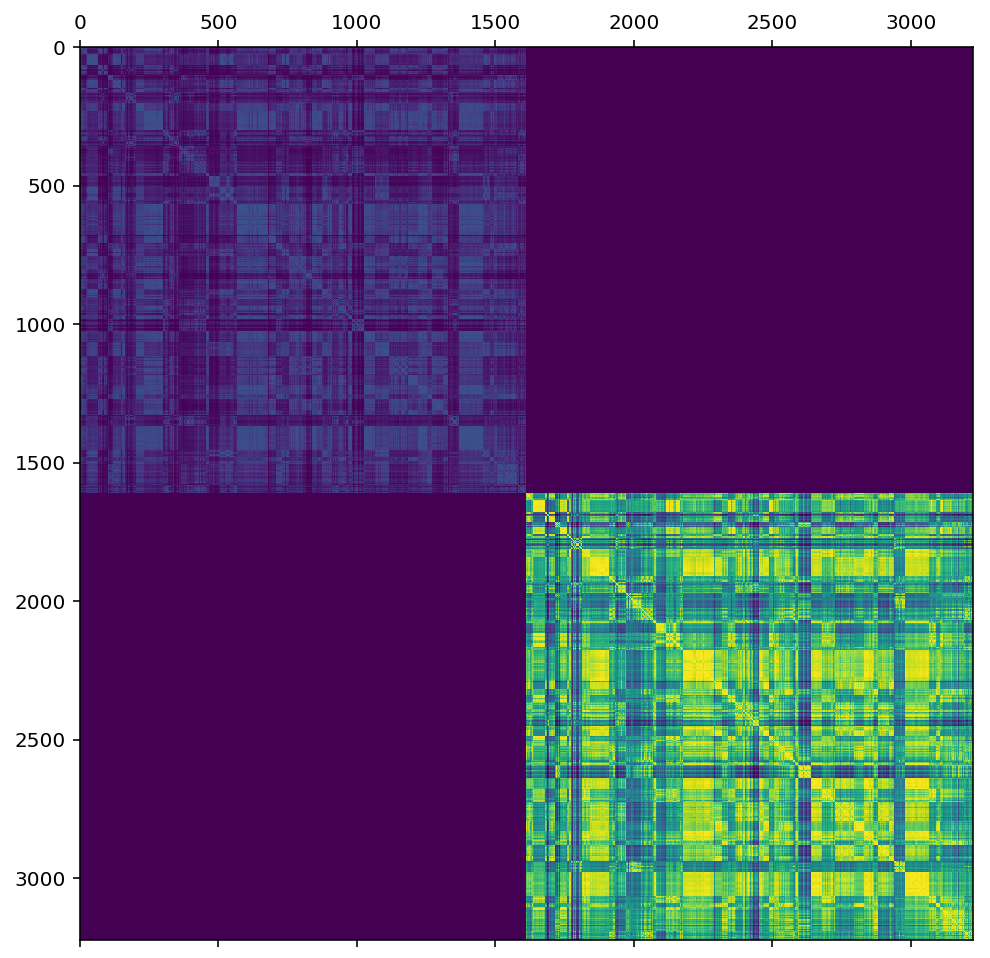

In [82]:
K1 = ard_rbf_kernel(covariates, covariates, np.linspace(2, 4, 8), 1., jitter=1e-5)
K2 = ard_rbf_kernel(covariates, covariates, np.linspace(3, 5, 8), 2., jitter=1e-5)

K = sps.block_diag([K1, K2], format='csc')

#K = sps.csc_matrix(K1)

plt.matshow(K.todense())
plt.gcf().set_size_inches(8, 8)

In [83]:
# Try to follow R & W to the letter

In [101]:
def find_mode(K, y):
    
    f = np.zeros(K.shape[0])
    old_f = np.ones_like(f)
    
    while np.sum((f - old_f)**2) > 1e-8:

        probs = expit(f)
        grad_log_y = y_flat - probs

        W = sps.csc_matrix(np.diag(probs * (1 - probs)))
        W_sqrt = np.sqrt(W)
        multiplied = W_sqrt.dot(K).dot(W_sqrt)

        B = multiplied + sps.eye(K.shape[0], format='csc')
        L = cholesky(B)
        b = W.dot(f) + grad_log_y

        first_solve = L.solve_L(W_sqrt.dot(K.dot(b)), False)
        second_solve = L.solve_Lt(first_solve, False)

        a = b - W_sqrt.dot(second_solve)
        old_f = f
        f = K.dot(a)
        
    # Calculate the log marginal likelihood
    log_lik = np.sum(y * f - np.log1p(np.exp(f)))
    log_marg_lik = -0.5 * a.T.dot(f) + log_lik - np.log(L.L().diagonal()).sum()

    return f, log_marg_lik

In [103]:
f_mode, log_marg_lik = find_mode(K, y_flat)

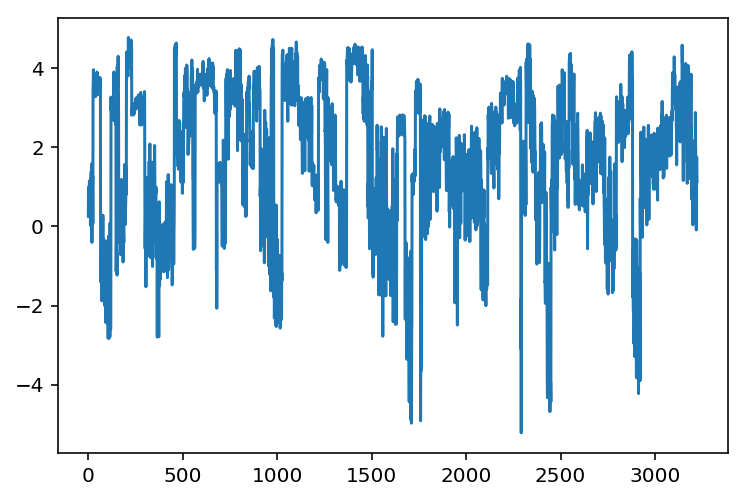

In [104]:
plt.plot(f_mode)